In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("attributes_std.csv", index_col=0)
df.head()

,area,eccentricity,extent,GLCM Contrast,GLCM dissimilarity,GLCM homogeneity,GLCM ASM,GLCM energy,GLCM correlation,hist_r4,...,hist_v9,hist_v10,hist_v11,hist_v12,hist_v13,hist_v14,hist_v15,hist_v16,hist_v17,Class
0,0.043333,-2.226854,0.363292,-1.542844,0.091402,0.646588,-0.157328,0.071042,-1.542844,-0.089535,...,1.059728,1.955997,1.911448,0.967515,-0.302177,0.080586,1.363820,2.254121,-0.258405,FBO1
1,0.049185,-2.203262,0.934037,0.913422,-1.606446,1.293831,1.704348,1.473114,0.913422,-0.089535,...,0.762793,1.869296,1.859591,1.112211,-0.054567,0.080586,1.217367,2.369830,0.464176,FBO1
2,0.043025,-2.231439,0.362645,-1.459200,-0.070608,0.710590,-0.076057,0.150221,-1.459200,-0.089535,...,1.072408,2.048186,1.842658,0.988737,-0.201795,0.046530,1.281440,2.264640,-0.258405,FBO1
3,0.051649,-2.219723,0.939462,0.426138,-0.348248,-0.847317,-1.104154,-1.280729,0.426138,-0.089535,...,0.696221,1.906610,1.834191,1.150797,-0.034490,-0.021582,1.263134,2.464500,0.388115,FBO1
4,0.042409,-2.227843,0.361352,-1.541941,0.098691,0.642377,-0.147996,0.080277,-1.541941,-0.089535,...,1.072408,1.962582,1.907214,0.944363,-0.248640,0.160050,1.308900,2.212045,-0.144313,FBO1


In [3]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

X = df.loc[:, df.columns != 'Class']

Y = df["Class"]
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
print(encoder.classes_)
Y = to_categorical(Y)

print(np.shape(X))
print(np.shape(Y))
print(Y[0])

['FBO1' 'FEAR5' 'FEC' 'FGI4' 'FSA12' 'FSV41']
(12896, 94)
(12896, 6)
[1. 0. 0. 0. 0. 0.]


In [4]:
# TRAIN/TEST SPLIT
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(10316, 94)
(10316, 6)
(2580, 94)
(2580, 6)


In [5]:
#HYPERPARAMETER GRID SEARCH
from keras import Sequential
from keras.layers import Dense, Dropout, Input
from keras.regularizers import L1
from keras.optimizers import Adam

num_classes = 6

model = Sequential()
model.add(Input(shape=(np.shape(X_train)[1],)))
model.add(Dense(64, activation='relu', kernel_regularizer=L1(0.001)))
model.add(Dense(32, activation='relu', kernel_regularizer=L1(0.001)))
model.add(Dense(16, activation='relu', kernel_regularizer=L1(0.001)))
model.add(Dropout(0.1))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           6,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,790 (34.34 KB)

 Trainable params: 8,790 (34.34 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

my_callbacks = [
    EarlyStopping(patience=5),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=1e-5)
]

H = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=128,
    validation_data=(X_test, Y_test),
    callbacks=my_callbacks)

Epoch 1/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5630 - loss: 2.1495 - val_accuracy: 0.9186 - val_loss: 1.1451 - learning_rate: 0.0010
Epoch 2/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9246 - loss: 1.0988 - val_accuracy: 0.9640 - val_loss: 0.8791 - learning_rate: 0.0010
Epoch 3/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9640 - loss: 0.8708 - val_accuracy: 0.9748 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 4/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9750 - loss: 0.7156 - val_accuracy: 0.9779 - val_loss: 0.6199 - learning_rate: 0.0010
Epoch 5/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 0.6150 - val_accuracy: 0.9822 - val_loss: 0.5313 - learning_rate: 0.0010
Epoch 6/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9803 - loss: 0.5250 - val_accuracy: 0.9814 - val_loss: 0.4622 - learning_rate: 0.0010
Epoch 7/100
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9833 - loss: 0.4573 - val_ac

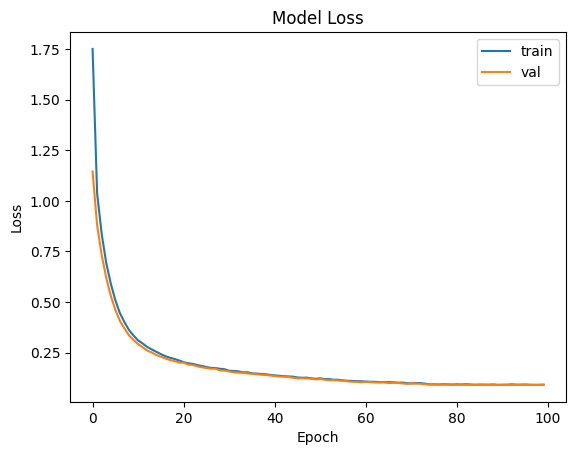

In [9]:
import matplotlib.pyplot as plt

plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


In [11]:
import pickle

# Save models with pickle
with open('mlp.pkl', 'wb') as f:
    pickle.dump(model, f)